In [31]:
import tensorflow as tf
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
import numpy as np

**Vamos baixar um modelo do Inception V3 pré treinado**

In [8]:
width = 299
height = 299
channels = 3

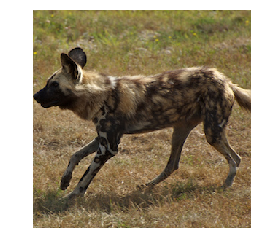

In [9]:
test_image = mpimg.imread(os.path.join("images", "cnn", "test_image.png"))[:, :, :channels]
plt.imshow(test_image)
plt.axis("off")
plt.show()

In [10]:
test_image.shape

(299, 299, 3)

O modelo Inception espera valores entre [-1, 1] em vez de [0 ,1], então temos que alterar a escala de velores

In [11]:
test_image = 2*test_image - 1 

Vamos baixar o modelo Inception pré-treinado

In [12]:
import sys
import tarfile
from six.moves import urllib

In [13]:
TF_MODELS_URL = "http://download.tensorflow.org/models"
INCEPTION_V3_URL = TF_MODELS_URL + "/inception_v3_2016_08_28.tar.gz"
INCEPTION_PATH = os.path.join("datasets", "inception")
INCEPTION_V3_CHECKPOINT_PATH = os.path.join(INCEPTION_PATH, "inception_v3.ckpt")

In [14]:
def download_progress(count, block_size, total_size):
    percent = count * block_size * 100 // total_size
    sys.stdout.write("\rDownloading: {}%".format(percent))
    sys.stdout.flush()

In [15]:
def fetch_pretrained_inception_v3(url=INCEPTION_V3_URL, path=INCEPTION_PATH):
    if os.path.exists(INCEPTION_V3_CHECKPOINT_PATH):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "inception_v3.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    inception_tgz = tarfile.open(tgz_path)
    inception_tgz.extractall(path=path)
    inception_tgz.close()
    os.remove(tgz_path)

In [16]:
fetch_pretrained_inception_v3()

In [17]:
import re

In [18]:
CLASS_NAME_REGEX = re.compile(r"^n\d+\s+(.*)\s*$", re.M | re.U)

In [19]:
def load_class_names():
    with open(os.path.join("datasets", "inception", "imagenet_class_names.txt"), "rb") as f:
        content = f.read().decode("utf-8")
        return CLASS_NAME_REGEX.findall(content)

In [20]:
class_names = ["background"] + load_class_names()

In [21]:
class_names[:5]

['background',
 'tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri']

**Agora podemos testá-lo em algumas imagens**

In [23]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [24]:
tf.reset_default_graph()

In [26]:
X = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="X")

In [29]:
X_test = test_image.reshape(-1, height, width, channels)

In [27]:
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(
        X, num_classes=1001 , is_training=False)
    predictions = end_points["Predictions"]
    saver = tf.train.Saver()

In [30]:
with tf.Session() as sess:
    saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    predictions_val = predictions.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt


In [32]:
mostly_likely_class_index = np.argmax(predictions_val[0])
mostly_likely_class_index

276

In [33]:
class_names[mostly_likely_class_index]

'African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus'

In [45]:
top_5 = np.argpartition(predictions_val[0], -5)[-5:]
top_5 = reversed(top_5[np.argsort(predictions_val[0][top_5])])

In [46]:
for i in top_5:
    print("{0}: {1:.2f}%".format(class_names[i], 100*predictions_val[0][i]))

African hunting dog, hyena dog, Cape hunting dog, Lycaon pictus: 93.13%
hyena, hyaena: 2.57%
European fire salamander, Salamandra salamandra: 0.06%
bearskin, busby, shako: 0.05%
swimming trunks, bathing trunks: 0.05%


<h3> Transfer Learning com imagens maiores </h4>

Para esta tarefa, vamos utilizar o dataset Flower do MIT

In [48]:
import sys
import tarfile
from six.moves import urllib

In [50]:
FLOWERS_URL = "http://download.tensorflow.org/example_images/flower_photos.tgz"
FLOWERS_PATH = os.path.join("datasets", "flowers")

In [63]:
def fetch_flowers(url=FLOWERS_URL, path=FLOWERS_PATH):
    if os.path.exists(path):
        return
    os.makedirs(path, exist_ok=True)
    tgz_path = os.path.join(path, "flowers_photos.tgz")
    urllib.request.urlretrieve(url, tgz_path, reporthook=download_progress)
    flowers_tgz = tarfile.open(tgz_path)
    flowers_tgz.extractall(path=path)
    flowers_tgz.close()
    os.remove(tgz_path)

In [64]:
fetch_flowers()

Downloading: 100%

Cada subpasta da pasta flower_photos possui as imagens referentes a sua classe. Vejamos a lista de classes

In [80]:
flowers_root_path = os.path.join(FLOWERS_PATH, "flower_photos")
flower_classes = sorted([dirname for dirname in os.listdir(flowers_root_path)
                         if os.path.isdir(os.path.join(flowers_root_path, dirname))])
flower_classes

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

agora vamos obter a lista de imagens para cada classe

In [81]:
from collections import defaultdict

In [82]:
image_paths = defaultdict(list)

In [83]:
for flower_class in flower_classes:
    image_dir = os.path.join(flowers_root_path, flower_class)
    for filepath in os.listdir(image_dir):
        if filepath.endswith(".jpg"):
            image_paths[flower_class].append(os.path.join(image_dir, filepath))

In [84]:
for paths in image_paths.values():
    paths.sort()

Agora podemos ver algumas imagens

In [85]:
import matplotlib.image as mpimg

In [86]:
n_examples_per_class = 2

Class: daisy


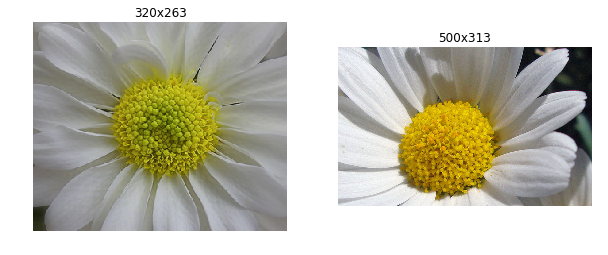

Class: dandelion


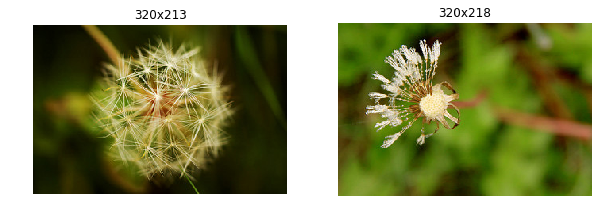

Class: roses


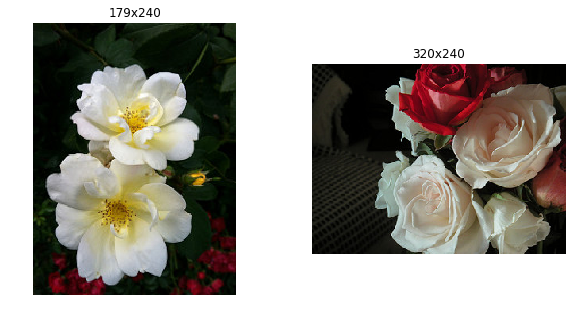

Class: sunflowers


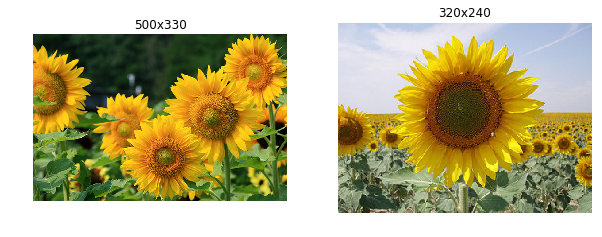

Class: tulips


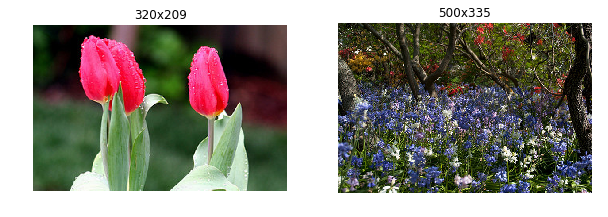

In [89]:
for flower_class in flower_classes:
    print("Class:", flower_class)
    plt.figure(figsize=(10,5))
    for index, example_image_path in enumerate(image_paths[flower_class][:n_examples_per_class]):
        example_image = mpimg.imread(example_image_path)[:, :, :channels]
        plt.subplot(100 + n_examples_per_class*10 + index + 1)
        plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
        plt.imshow(example_image)
        plt.axis("off")
    plt.show()

Agora vamos criar um método para redimensionar nossa imagem para 299x299 e aumentar o dataset, , por exemplo girando as imagens horizontalmente.

In [91]:
from scipy.misc import imresize

In [97]:
def prepare_image(image, target_width=299, target_height=299, max_zoom=0.2):
    #vamos encontrar o maior quadro delimitante do tamanho final que caiba a imagem
    height = image.shape[0]
    width = image.shape[1]
    image_ratio = width/height
    target_image_ratio = target_width/target_height
    crop_vertically = image_ratio < target_image_ratio
    crop_width = width if crop_vertically else int(height*target_image_ratio)
    crop_height = int(width / target_image_ratio) if crop_vertically else height

    #agora vamos diminuir o tamanho desse quadro divindo as domensões por valores aleatorios entre 1.0 e 1.0 + max_zoom
    resize_factor = np.random.rand() * max_zoom + 1.0
    crop_width = int(crop_width / resize_factor)
    crop_height = int(crop_height / resize_factor)
    
    #vamos colocar nosso quadro delimitante em uma localizacao aleatoria da imagem, selecionando partes aleatorias da mesma
    x0 = np.random.randint(0, width - crop_width)
    y0 = np.random.randint(0, height - crop_height)
    x1 = x0 + crop_width
    y1 = y0 + crop_height
    
    #recortando a imagem utilizando o quadro
    image = image[y0:y1, x0:x1]
    
    #podemos inverte-la horizontamente ocm probabilidade 0.5
    if np.random.rand() < 0.5:
        image = np.fliplr(image)
    
    #redimensiona para o tamanho definido
    image = imresize(image, (target_width, target_height))
    
    return image.astype(np.float32) / 255 #garante 32bits floats entre 0 e 1 para as cores

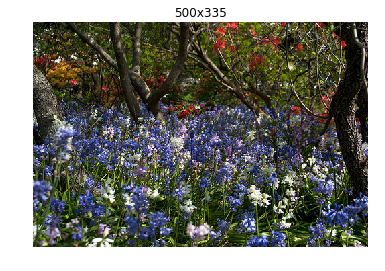

In [98]:
plt.figure(figsize=(6, 8))
plt.imshow(example_image)
plt.title("{}x{}".format(example_image.shape[1], example_image.shape[0]))
plt.axis("off")
plt.show()

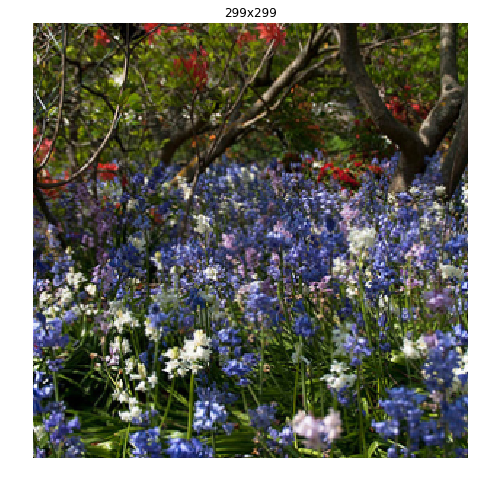

In [99]:
prepared_image = prepare_image(example_image)

plt.figure(figsize=(8, 8))
plt.imshow(prepared_image)
plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
plt.axis("off")
plt.show()

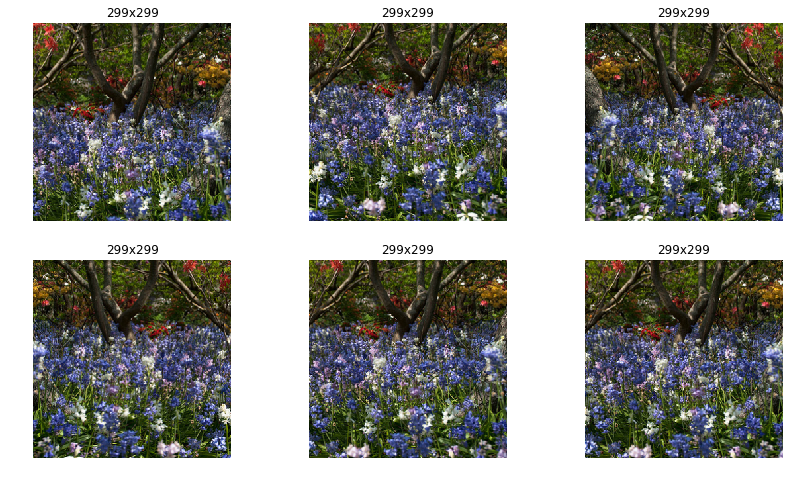

In [100]:
rows, cols = 2, 3

plt.figure(figsize=(14, 8))
for row in range(rows):
    for col in range(cols):
        prepared_image = prepare_image(example_image)
        plt.subplot(rows, cols, row * cols + col + 1)
        plt.title("{}x{}".format(prepared_image.shape[1], prepared_image.shape[0]))
        plt.imshow(prepared_image)
        plt.axis("off")
plt.show()

Vamos aproveitar a rede Inception pre treinada, remover sua última camada (de classificação) e adicionar a nossa softmax com o número de classes que usaremos neste problema (5 classes do flowers dataset).
A fim treina-la para esta tarefa, iremos congelar as camadas inferiores da Inception e atualizar os pesos apenas da nossa nova camada (softmax)

In [185]:
from tensorflow.contrib.slim.nets import inception
import tensorflow.contrib.slim as slim

In [186]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, height, width, channels], name="X")
training = tf.placeholder_with_default(False, shape=[])
with slim.arg_scope(inception.inception_v3_arg_scope()):
    logits, end_points = inception.inception_v3(X, num_classes=1001, is_training=training)
    
inception_saver = tf.train.Saver()

A função inception_V3() retorna um dicionário de end points, é só encontrar a última camada para plugar nossa rede

In [190]:
end_points

{'AuxLogits': <tf.Tensor 'InceptionV3/AuxLogits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'Conv2d_1a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_1a_3x3/Relu:0' shape=(?, 149, 149, 32) dtype=float32>,
 'Conv2d_2a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2a_3x3/Relu:0' shape=(?, 147, 147, 32) dtype=float32>,
 'Conv2d_2b_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_2b_3x3/Relu:0' shape=(?, 147, 147, 64) dtype=float32>,
 'Conv2d_3b_1x1': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_3b_1x1/Relu:0' shape=(?, 73, 73, 80) dtype=float32>,
 'Conv2d_4a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/Conv2d_4a_3x3/Relu:0' shape=(?, 71, 71, 192) dtype=float32>,
 'Logits': <tf.Tensor 'InceptionV3/Logits/SpatialSqueeze:0' shape=(?, 1001) dtype=float32>,
 'MaxPool_3a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_3a_3x3/MaxPool:0' shape=(?, 73, 73, 64) dtype=float32>,
 'MaxPool_5a_3x3': <tf.Tensor 'InceptionV3/InceptionV3/MaxPool_5a_3x3/MaxPool:0' shape=(?, 35, 35, 192) dtype=floa

In [191]:
end_points["PreLogits"]

<tf.Tensor 'InceptionV3/Logits/Dropout_1b/cond/Merge:0' shape=(?, 1, 1, 2048) dtype=float32>

In [192]:
prelogits = tf.squeeze(end_points["PreLogits"], axis=[1, 2])

In [193]:
n_outputs = len(flower_classes)

with tf.name_scope("new_output_layer"):
    flower_logits = tf.layers.dense(prelogits, n_outputs, name="flower_logits")
    Y_proba = tf.nn.softmax(flower_logits, name="Y_proba")

In [195]:
y = tf.placeholder(tf.int32, shape=[None])

In [196]:
with tf.name_scope("train"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=flower_logits, labels=y)
    loss = tf.reduce_mean(xentropy)
    optimizer = tf.train.AdamOptimizer()
    flower_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="flower_logits")
    training_op = optimizer.minimize(loss, var_list=flower_vars)

In [197]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(flower_logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [198]:
with tf.name_scope("init_and_save"):
    init = tf.global_variables_initializer()
    saver = tf.train.Saver()

In [199]:
[v.name for v in flower_vars]

['flower_logits/kernel:0', 'flower_logits/bias:0']

**Dividindo o dataset em treino e teste**

In [201]:
flower_class_ids = {flower_class: index for index, flower_class in enumerate(flower_classes)}
flower_class_ids

{'daisy': 0, 'dandelion': 1, 'roses': 2, 'sunflowers': 3, 'tulips': 4}

In [202]:
flower_paths_and_classes = []
for flower_class, paths in image_paths.items():
    for path in paths:
        flower_paths_and_classes.append((path, flower_class_ids[flower_class]))

In [206]:
test_ratio = 0.2
train_size = int(len(flower_paths_and_classes) * (1 - test_ratio))

np.random.shuffle(flower_paths_and_classes)

flower_paths_and_classes_train = flower_paths_and_classes[:train_size]
flower_paths_and_classes_test = flower_paths_and_classes[train_size:]

In [207]:
flower_paths_and_classes_train[:3]

[('datasets/flowers/flower_photos/roses/165985535_7178ce6350.jpg', 2),
 ('datasets/flowers/flower_photos/dandelion/8689302100_be76a16ccc_n.jpg', 1),
 ('datasets/flowers/flower_photos/sunflowers/14244410747_22691ece4a_n.jpg', 3)]

Precisamos de uma funçao para preprocessar as imagens de teste e criar batches durante o treinamento

In [210]:
from random import sample

def prepare_batch(flower_paths_and_classes, batch_size):
    batch_paths_and_classes = sample(flower_paths_and_classes, batch_size)
    images = [mpimg.imread(path)[:, :, :channels] 
              for path, labels in batch_paths_and_classes]
    prepared_images = [prepare_image(image) for image in images]
    X_batch = 2*np.stack(prepared_images) - 1 #inception espera valores entre -1 e 1
    y_batch = np.array([labels for path, labels in batch_paths_and_classes], dtype=np.int32)
    return X_batch, y_batch

In [211]:
X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size=4)

In [213]:
print(X_batch.shape, X_batch.dtype)
print(y_batch.shape, y_batch.dtype)

(4, 299, 299, 3) float32
(4,) int32


In [214]:
X_test, y_test = prepare_batch(flower_paths_and_classes_test, batch_size=len(flower_paths_and_classes_test))

In [215]:
X_test.shape

(734, 299, 299, 3)

In [216]:
n_epochs = 10
batch_size = 40
n_iterations_per_epoch = len(flower_paths_and_classes_train) // batch_size

with tf.Session() as sess:
    init.run()
    inception_saver.restore(sess, INCEPTION_V3_CHECKPOINT_PATH)
    
    for epoch in range(n_epochs):
        print("Epoch", epoch, end="")
        for iteration in range(n_iterations_per_epoch):
            print(".", end="")
            X_batch, y_batch = prepare_batch(flower_paths_and_classes_train, batch_size)
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch, training: True})
            
        acc_train = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
        print(" Train accuracy:", acc_train)
        save_path = saver.save(sess, "./my_flowers_model")

INFO:tensorflow:Restoring parameters from datasets/inception/inception_v3.ckpt
Epoch 0......................................................................... Train accuracy: 0.6
Epoch 1......................................................................... Train accuracy: 0.65
Epoch 2......................................................................... Train accuracy: 0.575
Epoch 3......................................................................... Train accuracy: 0.675
Epoch 4......................................................................... Train accuracy: 0.7
Epoch 5......................................................................... Train accuracy: 0.675
Epoch 6......................................................................... Train accuracy: 0.65
Epoch 7......................................................................... Train accuracy: 0.725
Epoch 8......................................................................... Train accuracy: 0.7
Ep

In [217]:
n_test_batches = 10
X_test_batches = np.array_split(X_test, n_test_batches)
y_test_batches = np.array_split(y_test, n_test_batches)

with tf.Session() as sess:
    saver.restore(sess, "./my_flowers_model")

    print("Computing final accuracy on the test set (this will take a while)...")
    acc_test = np.mean([
        accuracy.eval(feed_dict={X: X_test_batch, y: y_test_batch})
        for X_test_batch, y_test_batch in zip(X_test_batches, y_test_batches)])
    print("Test accuracy:", acc_test)

INFO:tensorflow:Restoring parameters from ./my_flowers_model
Computing final accuracy on the test set (this will take a while)...
Test accuracy: 0.712588
